# Home Credit Default Risk

## About The Capstone Project

This notebook documents the end-to-end process of building, optimizing, and deploying a machine learning model to predict the likelihood of loan repayment default for Home Credit, a financial institution focused on providing credit to underserved populations.

## Goal

The goal of this project is to build a reliable machine learning model that predicts if a loan applicant will default (TARGET = 1) or repay (TARGET = 0). We aim for high accuracy—tracked with AUC-ROC—and a solution that’s easy to use in the real world. The final model will be deployed as an API to process applicant data, fitting smoothly into Home Credit’s operations.

## Plan

1. **Setup**: We’ll load the tools (like pandas, LightGBM, Optuna) and data (main application files and extra features from bureau, POS, etc.).
2. **Prepare Data**: We’ll split the data into features and target, divide it for training and testing, and sort out numerical and categorical columns. A pipeline will fill missing values, drop redundant features, and format categories.
3. **Build Model**: We’ll use LightGBM to create a pipeline that combines preprocessing and prediction for consistency.
4. **Improve Model**: We’ll tune LightGBM with Optuna to get better results and test if ensembles or extra data help.
5. **Ensemble Models**: We’ll combine LightGBM with other models (like XGBoost or CatBoost) into a voting ensemble to see if it boosts performance.
6. **Check Performance**: We’ll measure how well the model works with metrics (precision, recall, F1) and visuals (confusion matrix, ROC curve), focusing on AUC.
7. **Test Predictions**: We’ll run the model on the test data, save predictions, and compare different versions (basic, tuned, ensemble).
8. **Deploy**: We’ll package the model with Docker and FastAPI, then put it on Google Cloud Run as an API for real-time use, with steps to test it locally and online.

## Notebook Preparation

### Library Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

/Users/daniel/Library/Mobile Documents/com~apple~CloudDocs/Docs/TuringCollege/Module 4/Home Credit Default Risk/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read the Data

In [2]:
test = pd.read_csv('data/application_test.csv', encoding = 'ISO-8859-1')
train = pd.read_csv('data/application_train.csv', encoding = 'ISO-8859-1')

agg_bureau = pd.read_csv('data/agg_bureau_selected.csv')
agg_pos = pd.read_csv('data/agg_pos_selected.csv')
agg_prev = pd.read_csv('data/agg_prev_selected.csv')
agg_credit = pd.read_csv('data/agg_credit_selected.csv')

historical_data = [agg_bureau, agg_pos, agg_prev, agg_credit]


### Splitting features and Target

In [3]:
X = train.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)
y = train['TARGET']

### Set scale_pos_weight parameter

In [4]:
pos = y.sum()
neg = y.shape[0] - pos
scale_pos_weight = neg / pos

### Train-Test Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Identifying Feature Types

In [6]:
numerical_features = train.select_dtypes(include=['number'])
categorical_features = train.select_dtypes(exclude=['number'])

## Building a Full ML Pipeline with LighGBM

We’re going to build a full machine learning pipeline using LightGBM as the model. We're doing this so that all the steps from data preprocessing to training are handled in one place, cleanly and repeatably.

### Why LightGBM?

After testing several models, I chose LightGBM as the core of this pipeline because it performed best on the metrics that matter most for our highly imbalanced data—especially recall and F1 score.

While XGBoost and CatBoost had similar precision, LightGBM stood out with recall around 69%, compared to 62% from the others—a key difference since catching risky cases is our top priority.

That’s why this project focuses on a robust, optimized LightGBM pipeline, giving us the best shot at identifying positive cases effectively.

### Create a custom transformer to drop highly correlated features

In [7]:
class CorrelationFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.features_to_keep_ = None
        self.importances_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.feature_names_in_ = X.columns

        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        model = LGBMClassifier(is_unbalance=True, metric='auc', objective='binary')
        model.fit(X, y)
        importances = dict(zip(X.columns, model.feature_importances_))
        self.importances_ = importances

        to_drop = set()

        for col in upper.columns:
            for row in upper.index:
                if upper.loc[row, col] > self.threshold:
                    if importances[row] < importances[col]:
                        to_drop.add(row)
                    else:
                        to_drop.add(col)

        self.features_to_keep_ = [col for col in X.columns if col not in to_drop]
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return X[self.features_to_keep_]

### Building Pipeline

#### Numerical pipeline:
1. We’ll impute missing values with the median, because that’s more robust to outliers than the mean.
2. Then we’ll use our CorrelationFeatureSelector to remove redundant features.
3. This keeps our numeric data clean and non-repetitive before sending it to the model.

#### Categorical pipeline:

1. We'll fill in missing values using the most frequent category, because that's often a safe default when we don’t want to drop rows.
2. Then, we apply One-Hot Encoding to turn categorical variables into a numeric format the model can understand.
3. We also make sure to ignore unknown categories that might show up in future data.

In [8]:
def build_pipeline(numerical_features, categorical_features, params=None, classifier=None):
    if params is None:
        params = {}
    if classifier is None:
        classifier = LGBMClassifier

    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('feature_selector', CorrelationFeatureSelector(threshold=0.9))
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    if classifier == LGBMClassifier:
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LGBMClassifier(
                is_unbalance=True,
                metric='auc',
                objective='binary',
                **params
            ))
        ])
    else:
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier(**params))
        ])

    return model_pipeline

### Build and fit pipeline model

Now we’re going to build the final pipeline.
We stack the preprocessor (from above) and the LightGBM classifier together.
This way, whenever we call .fit() or .predict(), it will automatically run all preprocessing steps and then train or predict with LightGBM.

In [9]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=['number']).columns.tolist()

lgbm_model = build_pipeline(numerical_features, categorical_features)
lgbm_model.fit(X_train, y_train)
preds = lgbm_model.predict(X_val)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11168
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6135
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] 

### Inspect the pipeline structure

In [10]:
lgbm_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('feature_selector',
                                                                   CorrelationFeatureSelector())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID...
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True, metric='auc',
                                objective='binary'))])

### Evaluate model performance with classification report

In [11]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56538
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503



The model correctly identifies 69% of risky clients (high recall), but with very low confidence (only 17% precision), leading to a poor f1-score of 0.27. This means it's flagging many safe clients as risky, which could result in unfair loan rejections.

### Plot confusion matrix to visualize prediction accuracy

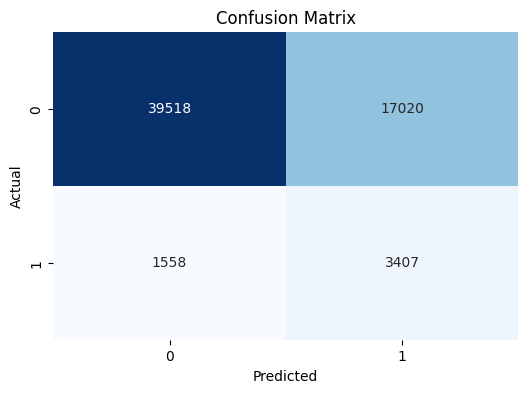

In [12]:
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model correctly identifies 3,407 risky clients (class 1), but wrongly labels 17,020 safe clients (class 0) as risky—showing high false positives and potential for unfair loan denials.

### Plot ROC curve and calculate AUC to assess model discrimination capability

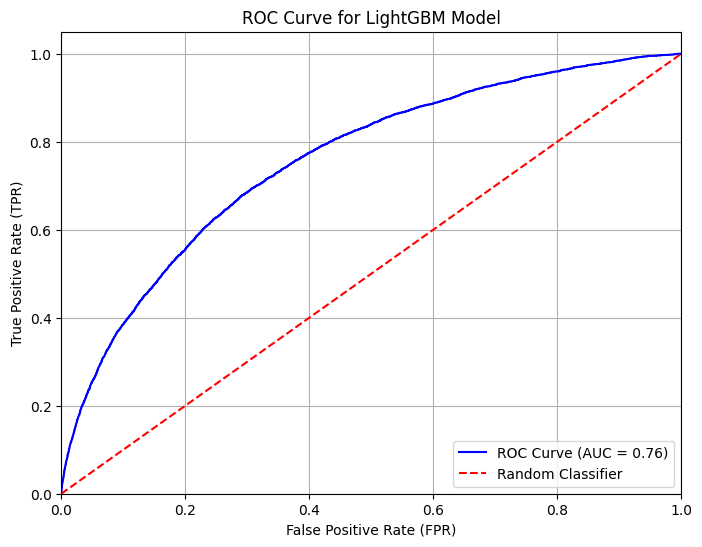

In [13]:
y_prob = lgbm_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LightGBM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The model has a decent ability to separate risky from safe clients, with an AUC of 0.76, meaning it correctly ranks a random risky client above a safe one 76% of the time.

In [14]:
predictions = lgbm_model.predict_proba(test)[:, 1]

# Create a DataFrame for the results
results_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})

# Export the results to a CSV file
results_df.to_csv('submissions/lgbm_model.csv', index=False)


## Hyperparameter Tuning

### Objective function for Optuna

In [15]:
def objective(trial, X, y, numerical_features, categorical_features):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42
    }

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = build_pipeline(numerical_features, categorical_features, params)
    pipeline.fit(X_train, y_train)

    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)

    return auc_score

def optimize_model(X, y, numerical_features, categorical_features, n_trials=100):
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    objective_func = lambda trial: objective(trial, X, y, numerical_features, categorical_features)
    study.optimize(objective_func, n_trials=n_trials)

    print('Best trial:')
    trial = study.best_trial
    print(f'  AUC Score: {trial.value}')
    print('  Best hyperparameters:')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

    best_params = trial.params
    best_params['random_state'] = 42
    best_pipeline = build_pipeline(numerical_features, categorical_features, best_params)
    return best_pipeline

### Build and fit pipeline model

In [16]:
lgbm_optuna = optimize_model(X, y, numerical_features, categorical_features, n_trials=50)
lgbm_optuna.fit(X, y)
y_pred = lgbm_optuna.predict(X_val)

[I 2025-04-15 13:35:09,059] A new study created in memory with name: no-name-640a9ba4-ec49-4c01-9e0a-0d02ef81e0ba


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6302
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 201
[LightGBM] [

[I 2025-04-15 13:35:33,538] Trial 0 finished with value: 0.73153752174289 and parameters: {'n_estimators': 406, 'learning_rate': 0.22648248189516848, 'max_depth': 12, 'num_leaves': 98, 'min_child_samples': 19, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.73153752174289.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:36:10,510] Trial 1 finished with value: 0.7482782224286619 and parameters: {'n_estimators': 723, 'learning_rate': 0.001124579825911934, 'max_depth': 15, 'num_leaves': 129, 'min_child_samples': 25, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.7482782224286619.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:36:34,321] Trial 2 finished with value: 0.7487979755853661 and parameters: {'n_estimators': 460, 'learning_rate': 0.005265139631677754, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 33, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 1.9967378215835974}. Best is trial 2 with value: 0.7487979755853661.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6302
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 201
[LightGBM] [

[I 2025-04-15 13:36:56,954] Trial 3 finished with value: 0.7537638304738821 and parameters: {'n_estimators': 539, 'learning_rate': 0.029341527565000736, 'max_depth': 3, 'num_leaves': 99, 'min_child_samples': 21, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.08397348116461}. Best is trial 3 with value: 0.7537638304738821.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6308
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 204
[LightGBM] [

[I 2025-04-15 13:37:21,098] Trial 4 finished with value: 0.7474017630036793 and parameters: {'n_estimators': 339, 'learning_rate': 0.0017456037635797405, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 16, 'subsample': 0.7475884550556351, 'colsample_bytree': 0.5171942605576092, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169}. Best is trial 3 with value: 0.7537638304738821.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6302
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 201
[LightGBM] [

[I 2025-04-15 13:37:50,316] Trial 5 finished with value: 0.7540880842141922 and parameters: {'n_estimators': 680, 'learning_rate': 0.005917607170144194, 'max_depth': 9, 'num_leaves': 91, 'min_child_samples': 22, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'reg_alpha': 9.394989415641891, 'reg_lambda': 8.948273504276488}. Best is trial 5 with value: 0.7540880842141922.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6312
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 206
[LightGBM] [

[I 2025-04-15 13:38:10,268] Trial 6 finished with value: 0.7527100826349334 and parameters: {'n_estimators': 618, 'learning_rate': 0.19212959255386391, 'max_depth': 4, 'num_leaves': 45, 'min_child_samples': 9, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 5 with value: 0.7540880842141922.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6286
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 193
[LightGBM] [

[I 2025-04-15 13:38:32,463] Trial 7 finished with value: 0.745491244130739 and parameters: {'n_estimators': 389, 'learning_rate': 0.0049648810171066555, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 82, 'subsample': 0.5372753218398854, 'colsample_bytree': 0.9934434683002586, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 5 with value: 0.7540880842141922.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6286
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 193
[LightGBM] [

[I 2025-04-15 13:38:49,279] Trial 8 finished with value: 0.7534505633595217 and parameters: {'n_estimators': 55, 'learning_rate': 0.10471209213501693, 'max_depth': 12, 'num_leaves': 115, 'min_child_samples': 79, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 5 with value: 0.7540880842141922.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:39:09,299] Trial 9 finished with value: 0.7428766165176557 and parameters: {'n_estimators': 642, 'learning_rate': 0.006601984958164864, 'max_depth': 3, 'num_leaves': 60, 'min_child_samples': 36, 'subsample': 0.864803089169032, 'colsample_bytree': 0.8187787356776066, 'reg_alpha': 8.872127425763265, 'reg_lambda': 4.722149251619493}. Best is trial 5 with value: 0.7540880842141922.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6294
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 197
[LightGBM] [

[I 2025-04-15 13:39:37,654] Trial 10 finished with value: 0.7562058662322874 and parameters: {'n_estimators': 965, 'learning_rate': 0.027023369486477284, 'max_depth': 7, 'num_leaves': 142, 'min_child_samples': 55, 'subsample': 0.9538323976412589, 'colsample_bytree': 0.8651834476035049, 'reg_alpha': 6.062890283015676, 'reg_lambda': 9.698960095003851}. Best is trial 10 with value: 0.7562058662322874.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6292
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 196
[LightGBM] [

[I 2025-04-15 13:40:06,869] Trial 11 finished with value: 0.756048555613118 and parameters: {'n_estimators': 998, 'learning_rate': 0.022848617465383633, 'max_depth': 7, 'num_leaves': 145, 'min_child_samples': 59, 'subsample': 0.9982635852231622, 'colsample_bytree': 0.852432976466373, 'reg_alpha': 5.84404466479791, 'reg_lambda': 9.989193151088612}. Best is trial 10 with value: 0.7562058662322874.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6292
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 196
[LightGBM] [

[I 2025-04-15 13:40:34,686] Trial 12 finished with value: 0.7550381290228335 and parameters: {'n_estimators': 969, 'learning_rate': 0.03529733963771393, 'max_depth': 7, 'num_leaves': 150, 'min_child_samples': 63, 'subsample': 0.9789035353260929, 'colsample_bytree': 0.8505812976968801, 'reg_alpha': 5.294482637724877, 'reg_lambda': 9.92038039655945}. Best is trial 10 with value: 0.7562058662322874.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6292
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 196
[LightGBM] [

[I 2025-04-15 13:41:01,072] Trial 13 finished with value: 0.7523965189709948 and parameters: {'n_estimators': 997, 'learning_rate': 0.05957344118902256, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 57, 'subsample': 0.8920033219388472, 'colsample_bytree': 0.9134916848203009, 'reg_alpha': 5.998073748639774, 'reg_lambda': 6.855046081289343}. Best is trial 10 with value: 0.7562058662322874.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6282
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 191
[LightGBM] [

[I 2025-04-15 13:41:26,416] Trial 14 finished with value: 0.7575160115513707 and parameters: {'n_estimators': 835, 'learning_rate': 0.015035506071792938, 'max_depth': 6, 'num_leaves': 129, 'min_child_samples': 100, 'subsample': 0.8758067124078945, 'colsample_bytree': 0.7793992915216572, 'reg_alpha': 6.361442678517976, 'reg_lambda': 3.8709162171321028}. Best is trial 14 with value: 0.7575160115513707.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6284
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 192
[LightGBM] [

[I 2025-04-15 13:41:50,934] Trial 15 finished with value: 0.7548244918481843 and parameters: {'n_estimators': 844, 'learning_rate': 0.009711191660373169, 'max_depth': 5, 'num_leaves': 126, 'min_child_samples': 96, 'subsample': 0.8698894808438722, 'colsample_bytree': 0.7703719760589351, 'reg_alpha': 4.254606859047973, 'reg_lambda': 3.743123068354829}. Best is trial 14 with value: 0.7575160115513707.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6286
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 193
[LightGBM] [

[I 2025-04-15 13:42:19,903] Trial 16 finished with value: 0.7575295313538404 and parameters: {'n_estimators': 824, 'learning_rate': 0.012230978481369342, 'max_depth': 8, 'num_leaves': 115, 'min_child_samples': 74, 'subsample': 0.8086893885957892, 'colsample_bytree': 0.7858037041718313, 'reg_alpha': 7.071944785663513, 'reg_lambda': 0.13179214380923554}. Best is trial 16 with value: 0.7575295313538404.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6284
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 192
[LightGBM] [

[I 2025-04-15 13:42:48,141] Trial 17 finished with value: 0.7572186116259025 and parameters: {'n_estimators': 807, 'learning_rate': 0.012091785658158206, 'max_depth': 8, 'num_leaves': 113, 'min_child_samples': 97, 'subsample': 0.8085311011158838, 'colsample_bytree': 0.7730119448025031, 'reg_alpha': 7.62217795391978, 'reg_lambda': 0.2550058003430702}. Best is trial 16 with value: 0.7575295313538404.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6286
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 193
[LightGBM] [

[I 2025-04-15 13:43:13,932] Trial 18 finished with value: 0.7452167553398735 and parameters: {'n_estimators': 834, 'learning_rate': 0.0025669484313400564, 'max_depth': 5, 'num_leaves': 76, 'min_child_samples': 76, 'subsample': 0.795758835497863, 'colsample_bytree': 0.6345569096715945, 'reg_alpha': 4.241018061506212, 'reg_lambda': 0.20034877225580455}. Best is trial 16 with value: 0.7575295313538404.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6284
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 192
[LightGBM] [

[I 2025-04-15 13:43:34,913] Trial 19 finished with value: 0.7538881169032452 and parameters: {'n_estimators': 229, 'learning_rate': 0.014922448290599246, 'max_depth': 14, 'num_leaves': 119, 'min_child_samples': 89, 'subsample': 0.9132589822689006, 'colsample_bytree': 0.8062087819447984, 'reg_alpha': 7.017304757414718, 'reg_lambda': 3.142957720771854}. Best is trial 16 with value: 0.7575295313538404.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6288
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 194
[LightGBM] [

[I 2025-04-15 13:44:01,890] Trial 20 finished with value: 0.7490206414441698 and parameters: {'n_estimators': 760, 'learning_rate': 0.04990147515576534, 'max_depth': 9, 'num_leaves': 107, 'min_child_samples': 68, 'subsample': 0.8199212859905155, 'colsample_bytree': 0.933040279602396, 'reg_alpha': 0.11620961627552884, 'reg_lambda': 1.170823531751921}. Best is trial 16 with value: 0.7575295313538404.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6282
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 191
[LightGBM] [

[I 2025-04-15 13:44:29,712] Trial 21 finished with value: 0.757208089475196 and parameters: {'n_estimators': 876, 'learning_rate': 0.012417399041583106, 'max_depth': 7, 'num_leaves': 134, 'min_child_samples': 98, 'subsample': 0.7655861314080078, 'colsample_bytree': 0.7586440907951697, 'reg_alpha': 6.9165442619939865, 'reg_lambda': 0.10005752461190165}. Best is trial 16 with value: 0.7575295313538404.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6284
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 192
[LightGBM] [

[I 2025-04-15 13:44:58,877] Trial 22 finished with value: 0.7567769921373559 and parameters: {'n_estimators': 779, 'learning_rate': 0.009733029920405476, 'max_depth': 8, 'num_leaves': 112, 'min_child_samples': 92, 'subsample': 0.8293716000893924, 'colsample_bytree': 0.7951636917450593, 'reg_alpha': 7.179939586243442, 'reg_lambda': 1.1544979113299276}. Best is trial 16 with value: 0.7575295313538404.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6284
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 192
[LightGBM] [

[I 2025-04-15 13:45:24,094] Trial 23 finished with value: 0.7581604316498489 and parameters: {'n_estimators': 877, 'learning_rate': 0.016053793274858223, 'max_depth': 8, 'num_leaves': 22, 'min_child_samples': 85, 'subsample': 0.7199267668895423, 'colsample_bytree': 0.7209083041526617, 'reg_alpha': 8.148272405058856, 'reg_lambda': 1.073158132774278}. Best is trial 23 with value: 0.7581604316498489.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6284
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 192
[LightGBM] [

[I 2025-04-15 13:45:49,963] Trial 24 finished with value: 0.746265302842539 and parameters: {'n_estimators': 870, 'learning_rate': 0.0032138939784549275, 'max_depth': 5, 'num_leaves': 28, 'min_child_samples': 85, 'subsample': 0.7061263810064461, 'colsample_bytree': 0.7145275955917266, 'reg_alpha': 6.536718994795306, 'reg_lambda': 3.9458094547108145}. Best is trial 23 with value: 0.7581604316498489.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6288
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 194
[LightGBM] [

[I 2025-04-15 13:46:15,918] Trial 25 finished with value: 0.7577680108082389 and parameters: {'n_estimators': 909, 'learning_rate': 0.019209312342929302, 'max_depth': 6, 'num_leaves': 66, 'min_child_samples': 71, 'subsample': 0.739013540248122, 'colsample_bytree': 0.6567248926683473, 'reg_alpha': 8.26986331882944, 'reg_lambda': 1.1559214816553074}. Best is trial 23 with value: 0.7581604316498489.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6288
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 194
[LightGBM] [

[I 2025-04-15 13:46:39,380] Trial 26 finished with value: 0.7558782825617708 and parameters: {'n_estimators': 905, 'learning_rate': 0.07285182510036017, 'max_depth': 9, 'num_leaves': 21, 'min_child_samples': 72, 'subsample': 0.7225694545729975, 'colsample_bytree': 0.6484544626940177, 'reg_alpha': 8.213490618747795, 'reg_lambda': 0.997246516080608}. Best is trial 23 with value: 0.7581604316498489.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6290
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 195
[LightGBM] [

[I 2025-04-15 13:47:03,910] Trial 27 finished with value: 0.7587768653284687 and parameters: {'n_estimators': 581, 'learning_rate': 0.02012730929655582, 'max_depth': 8, 'num_leaves': 59, 'min_child_samples': 65, 'subsample': 0.6493460321192701, 'colsample_bytree': 0.6263668684551994, 'reg_alpha': 9.916417914043084, 'reg_lambda': 1.9212897883719415}. Best is trial 27 with value: 0.7587768653284687.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6296
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 198
[LightGBM] [

[I 2025-04-15 13:47:26,098] Trial 28 finished with value: 0.7506440252945215 and parameters: {'n_estimators': 539, 'learning_rate': 0.11478567626636407, 'max_depth': 6, 'num_leaves': 61, 'min_child_samples': 48, 'subsample': 0.6338178975967547, 'colsample_bytree': 0.5949957407428388, 'reg_alpha': 9.906256709151041, 'reg_lambda': 1.9552728827790595}. Best is trial 27 with value: 0.7587768653284687.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6298
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 199
[LightGBM] [

[I 2025-04-15 13:47:54,375] Trial 29 finished with value: 0.7592630923048149 and parameters: {'n_estimators': 608, 'learning_rate': 0.020681532284800037, 'max_depth': 11, 'num_leaves': 56, 'min_child_samples': 47, 'subsample': 0.619720671481651, 'colsample_bytree': 0.5509435966413281, 'reg_alpha': 8.538116981236033, 'reg_lambda': 2.843171554477623}. Best is trial 29 with value: 0.7592630923048149.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6296
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 198
[LightGBM] [

[I 2025-04-15 13:48:20,112] Trial 30 finished with value: 0.7579781715643352 and parameters: {'n_estimators': 593, 'learning_rate': 0.042672801952995026, 'max_depth': 13, 'num_leaves': 51, 'min_child_samples': 48, 'subsample': 0.5859368086055616, 'colsample_bytree': 0.5615546708760338, 'reg_alpha': 8.645440342049158, 'reg_lambda': 2.6757400619311666}. Best is trial 29 with value: 0.7592630923048149.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6298
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 199
[LightGBM] [

[I 2025-04-15 13:48:45,606] Trial 31 finished with value: 0.7582325646551503 and parameters: {'n_estimators': 596, 'learning_rate': 0.04138834133021552, 'max_depth': 13, 'num_leaves': 51, 'min_child_samples': 47, 'subsample': 0.6048015988570616, 'colsample_bytree': 0.5659683842399351, 'reg_alpha': 8.702728206350677, 'reg_lambda': 2.9824518936460342}. Best is trial 29 with value: 0.7592630923048149.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:49:13,077] Trial 32 finished with value: 0.7597592268953918 and parameters: {'n_estimators': 713, 'learning_rate': 0.023116031563045404, 'max_depth': 12, 'num_leaves': 51, 'min_child_samples': 39, 'subsample': 0.6257309789230707, 'colsample_bytree': 0.556799784884323, 'reg_alpha': 8.84866628300073, 'reg_lambda': 5.340483426573153}. Best is trial 32 with value: 0.7597592268953918.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:49:38,481] Trial 33 finished with value: 0.7530147462386312 and parameters: {'n_estimators': 712, 'learning_rate': 0.07950750622635956, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 39, 'subsample': 0.635783714920184, 'colsample_bytree': 0.550264176104183, 'reg_alpha': 9.990800753016995, 'reg_lambda': 5.904115422393953}. Best is trial 32 with value: 0.7597592268953918.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6298
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 199
[LightGBM] [

[I 2025-04-15 13:50:02,394] Trial 34 finished with value: 0.7591798154665583 and parameters: {'n_estimators': 502, 'learning_rate': 0.036748143644810986, 'max_depth': 14, 'num_leaves': 68, 'min_child_samples': 43, 'subsample': 0.6289622608128737, 'colsample_bytree': 0.5966927956107516, 'reg_alpha': 9.14820097680121, 'reg_lambda': 4.921235711101773}. Best is trial 32 with value: 0.7597592268953918.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:50:28,702] Trial 35 finished with value: 0.7597254023790122 and parameters: {'n_estimators': 490, 'learning_rate': 0.02763201738931862, 'max_depth': 15, 'num_leaves': 73, 'min_child_samples': 40, 'subsample': 0.6678245216424936, 'colsample_bytree': 0.5032961690167688, 'reg_alpha': 9.371154205409558, 'reg_lambda': 6.920357773786554}. Best is trial 32 with value: 0.7597592268953918.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:50:53,919] Trial 36 finished with value: 0.7599275598693761 and parameters: {'n_estimators': 441, 'learning_rate': 0.03157619543276582, 'max_depth': 15, 'num_leaves': 75, 'min_child_samples': 31, 'subsample': 0.6792792669364831, 'colsample_bytree': 0.5021345958158536, 'reg_alpha': 9.251871265374733, 'reg_lambda': 6.605673747598061}. Best is trial 36 with value: 0.7599275598693761.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:51:19,684] Trial 37 finished with value: 0.7594228574970017 and parameters: {'n_estimators': 442, 'learning_rate': 0.026972125653515526, 'max_depth': 15, 'num_leaves': 82, 'min_child_samples': 29, 'subsample': 0.6836072301017342, 'colsample_bytree': 0.5014187158791529, 'reg_alpha': 9.328568033787874, 'reg_lambda': 7.242806754552044}. Best is trial 36 with value: 0.7599275598693761.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:51:42,870] Trial 38 finished with value: 0.759052188388329 and parameters: {'n_estimators': 297, 'learning_rate': 0.028881862985472753, 'max_depth': 15, 'num_leaves': 83, 'min_child_samples': 29, 'subsample': 0.6787691863385867, 'colsample_bytree': 0.5052859897228105, 'reg_alpha': 9.342678525920661, 'reg_lambda': 7.205313517031438}. Best is trial 36 with value: 0.7599275598693761.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6308
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 204
[LightGBM] [

[I 2025-04-15 13:52:07,072] Trial 39 finished with value: 0.7398976366592103 and parameters: {'n_estimators': 456, 'learning_rate': 0.17313255173898648, 'max_depth': 15, 'num_leaves': 94, 'min_child_samples': 14, 'subsample': 0.503749323085364, 'colsample_bytree': 0.5241021091452714, 'reg_alpha': 9.38885735187357, 'reg_lambda': 6.99715435956342}. Best is trial 36 with value: 0.7599275598693761.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:52:30,640] Trial 40 finished with value: 0.7273942310731323 and parameters: {'n_estimators': 403, 'learning_rate': 0.2738452654368814, 'max_depth': 14, 'num_leaves': 83, 'min_child_samples': 26, 'subsample': 0.5538863746201979, 'colsample_bytree': 0.5007250058963767, 'reg_alpha': 7.946698176419814, 'reg_lambda': 6.039859293195301}. Best is trial 36 with value: 0.7599275598693761.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:52:55,903] Trial 41 finished with value: 0.7599346520490543 and parameters: {'n_estimators': 468, 'learning_rate': 0.025395203894867487, 'max_depth': 11, 'num_leaves': 75, 'min_child_samples': 32, 'subsample': 0.6746975441771746, 'colsample_bytree': 0.5394888267036632, 'reg_alpha': 8.683492503934032, 'reg_lambda': 5.672175923858617}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:53:20,626] Trial 42 finished with value: 0.7594222894080501 and parameters: {'n_estimators': 453, 'learning_rate': 0.03242364865676375, 'max_depth': 15, 'num_leaves': 75, 'min_child_samples': 30, 'subsample': 0.6871181400809191, 'colsample_bytree': 0.5329579699534751, 'reg_alpha': 9.032477413305068, 'reg_lambda': 7.631302040196821}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6302
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 201
[LightGBM] [

[I 2025-04-15 13:53:44,473] Trial 43 finished with value: 0.7594887486696089 and parameters: {'n_estimators': 353, 'learning_rate': 0.023260178297062027, 'max_depth': 13, 'num_leaves': 89, 'min_child_samples': 20, 'subsample': 0.6712853535013055, 'colsample_bytree': 0.5325512948634112, 'reg_alpha': 9.437890880189691, 'reg_lambda': 6.2495971981287255}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6302
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 201
[LightGBM] [

[I 2025-04-15 13:54:06,633] Trial 44 finished with value: 0.7559402114032632 and parameters: {'n_estimators': 340, 'learning_rate': 0.05572440386375711, 'max_depth': 13, 'num_leaves': 89, 'min_child_samples': 19, 'subsample': 0.6590613982779852, 'colsample_bytree': 0.5833195045081401, 'reg_alpha': 7.5389773520034575, 'reg_lambda': 6.276555692703244}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6312
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 206
[LightGBM] [

[I 2025-04-15 13:54:27,547] Trial 45 finished with value: 0.7504378375881994 and parameters: {'n_estimators': 208, 'learning_rate': 0.007742015431903411, 'max_depth': 11, 'num_leaves': 99, 'min_child_samples': 5, 'subsample': 0.7686787359488332, 'colsample_bytree': 0.5387758001376743, 'reg_alpha': 2.469565884473597, 'reg_lambda': 5.523016683061392}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:54:52,348] Trial 46 finished with value: 0.7594944224133516 and parameters: {'n_estimators': 497, 'learning_rate': 0.02339810095155495, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 36, 'subsample': 0.5760248548509145, 'colsample_bytree': 0.5749715892008888, 'reg_alpha': 9.554083803512388, 'reg_lambda': 6.496365390708371}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:55:15,558] Trial 47 finished with value: 0.7513246565975533 and parameters: {'n_estimators': 514, 'learning_rate': 0.08104990625893076, 'max_depth': 12, 'num_leaves': 71, 'min_child_samples': 36, 'subsample': 0.5746437633604734, 'colsample_bytree': 0.5850219176180521, 'reg_alpha': 8.802420128916243, 'reg_lambda': 4.4648852890587065}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:55:39,237] Trial 48 finished with value: 0.7592956806024699 and parameters: {'n_estimators': 647, 'learning_rate': 0.04365958703775719, 'max_depth': 11, 'num_leaves': 43, 'min_child_samples': 40, 'subsample': 0.560916594973496, 'colsample_bytree': 0.6213400152691377, 'reg_alpha': 8.451272529227833, 'reg_lambda': 5.480085438101274}. Best is trial 41 with value: 0.7599346520490543.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 200
[LightGBM] [

[I 2025-04-15 13:56:05,914] Trial 49 finished with value: 0.7508928018077777 and parameters: {'n_estimators': 544, 'learning_rate': 0.004279638322371863, 'max_depth': 10, 'num_leaves': 65, 'min_child_samples': 34, 'subsample': 0.6017441624510846, 'colsample_bytree': 0.5728193790658085, 'reg_alpha': 9.625724716250186, 'reg_lambda': 6.636823366935084}. Best is trial 41 with value: 0.7599346520490543.


Best trial:
  AUC Score: 0.7599346520490543
  Best hyperparameters:
    n_estimators: 468
    learning_rate: 0.025395203894867487
    max_depth: 11
    num_leaves: 75
    min_child_samples: 32
    subsample: 0.6746975441771746
    colsample_bytree: 0.5394888267036632
    reg_alpha: 8.683492503934032
    reg_lambda: 5.672175923858617
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11149
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing

### Inspect the pipeline structure

In [17]:
lgbm_optuna

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('feature_selector',
                                                                   CorrelationFeatureSelector())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID...
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5394888267036632,
                                is_unbalance=True,
                                learning_rate=0.025395203894867487,
                                max_depth=11, metric='auc',
                                min_child_samples=32, n_estimators=468,
                                num_leaves=75, objective='binary',
                                random_state=42, reg_alpha=8.683492503934032,
                                reg_lambda=5.672175923858617,
                                subsample=0.6746975441771746))])

### Evaluate model performance with classification report

In [18]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.73      0.84     56538
           1       0.20      0.77      0.32      4965

    accuracy                           0.74     61503
   macro avg       0.59      0.75      0.58     61503
weighted avg       0.91      0.74      0.79     61503



After tuning, the model improved for both classes. For class 0 (safe clients), recall rose from 0.70 to 0.73 and f1-score increased from 0.81 to 0.84. For class 1 (risky clients), recall went up from 0.69 to 0.77, precision improved from 0.17 to 0.20, and f1-score climbed from 0.27 to 0.32—allowing the model to catch more risky clients while reducing false alarms.

### Plot confusion matrix to visualize prediction accuracy

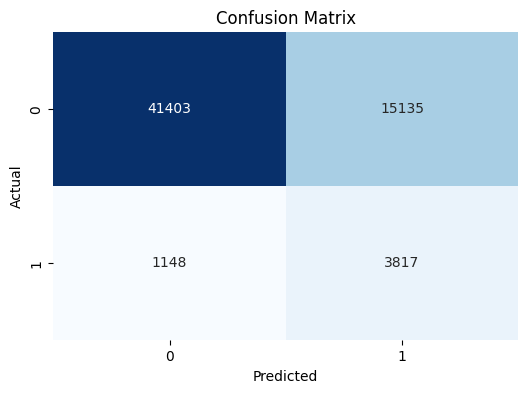

In [19]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The base model correctly predicted 39,518 safe clients and 3,407 risky clients, while the tuned model improved to 41,403 safe and 3,817 risky correct predictions. False alarms on safe clients dropped from 17,020 to 15,135, and missed risky clients decreased from 1,558 to 1,148—showing better overall accuracy and balance.

### Plot ROC curve and calculate AUC to assess model discrimination capability

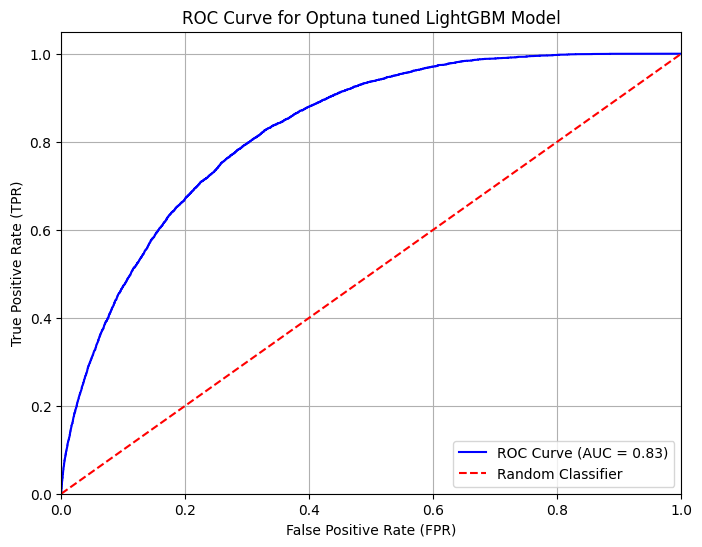

In [55]:
y_prob = lgbm_optuna.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Optuna tuned LightGBM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

After tuning, the AUC improved from 0.76 to 0.83, meaning the model became better at ranking risky clients above safe ones—overall discrimination power increased.

In [21]:
predictions = lgbm_optuna.predict_proba(test)[:, 1]

# Create a DataFrame for the results
results_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})

# Export the results to a CSV file
results_df.to_csv('submissions/lgbm_optuna.csv', index=False)


## Ensemble Pipeline

The pipeline trains an ensemble of LightGBM, XGBoost, and CatBoost models using soft voting with equal weights to boost prediction accuracy and stability. Each model handles class imbalance in its own way: LightGBM uses is_unbalance=True, XGBoost uses scale_pos_weight, and CatBoost uses auto_class_weights='Balanced'.

In [22]:
def objective_xgb(trial, X, y, numerical_features, categorical_features):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = build_pipeline(numerical_features, categorical_features, params, XGBClassifier)
    pipeline.fit(X_train, y_train)

    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)

    return auc_score

# Objective function for CatBoost
def objective_cat(trial, X, y, numerical_features, categorical_features):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'random_seed': 42,
        'auto_class_weights': 'Balanced',
        'verbose': 0
    }

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = build_pipeline(numerical_features, categorical_features, params, CatBoostClassifier)
    pipeline.fit(X_train, y_train)

    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)

    return auc_score

### Build and fit pipeline model

In [23]:
def optimize_model(X, y, numerical_features, categorical_features, classifier, objective_func, n_trials=50):
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    objective = lambda trial: objective_func(trial, X, y, numerical_features, categorical_features)
    study.optimize(objective, n_trials=n_trials)

    print(f'Best trial for {classifier.__name__}:')
    trial = study.best_trial
    print(f'  AUC Score: {trial.value}')
    print('  Best hyperparameters:')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

    best_params = trial.params
    if classifier == CatBoostClassifier:
        best_params['random_seed'] = 42
        best_params['verbose'] = 0
        best_params['auto_class_weights'] = 'Balanced'
    else:
        best_params['random_state'] = 42
    best_pipeline = build_pipeline(numerical_features, categorical_features, best_params, classifier)
    return best_pipeline

In [24]:
print("\nOptimizing XGBoost...")
xgb_pipeline = optimize_model(
    X, y, numerical_features, categorical_features,
    classifier=XGBClassifier,
    objective_func=objective_xgb,
    n_trials=50
)

print("\nOptimizing CatBoost...")
cat_pipeline = optimize_model(
    X, y, numerical_features, categorical_features,
    classifier=CatBoostClassifier,
    objective_func=objective_cat,
    n_trials=50
)

[I 2025-04-15 13:56:39,882] A new study created in memory with name: no-name-086fcb21-9ddb-422d-ab82-0f0417356dae



Optimizing XGBoost...
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 13:57:20,980] Trial 0 finished with value: 0.71424699134196 and parameters: {'n_estimators': 406, 'learning_rate': 0.22648248189516848, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088, 'scale_pos_weight': 7.372653200164409}. Best is trial 0 with value: 0.71424699134196.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 13:57:41,600] Trial 1 finished with value: 0.7184394234924705 and parameters: {'n_estimators': 69, 'learning_rate': 0.2526878207508456, 'max_depth': 13, 'min_child_weight': 3, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'gamma': 1.5212112147976886, 'reg_alpha': 5.247564316322379, 'reg_lambda': 4.319450186421157, 'scale_pos_weight': 3.6210622617823773}. Best is trial 1 with value: 0.7184394234924705.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 13:58:22,190] Trial 2 finished with value: 0.737530531476226 and parameters: {'n_estimators': 631, 'learning_rate': 0.0022158645374549917, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'gamma': 0.9983689107917987, 'reg_alpha': 5.142344384136116, 'reg_lambda': 5.924145688620425, 'scale_pos_weight': 1.4180537144799796}. Best is trial 2 with value: 0.737530531476226.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 13:58:53,595] Trial 3 finished with value: 0.7254288362366264 and parameters: {'n_estimators': 627, 'learning_rate': 0.0026448980183927102, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9828160165372797, 'colsample_bytree': 0.9041986740582306, 'gamma': 1.5230688458668533, 'reg_alpha': 0.9767211400638387, 'reg_lambda': 6.842330265121569, 'scale_pos_weight': 4.961372443656412}. Best is trial 2 with value: 0.737530531476226.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 13:59:13,193] Trial 4 finished with value: 0.7353811026160653 and parameters: {'n_estimators': 166, 'learning_rate': 0.016850517723339092, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'gamma': 1.5585553804470549, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965, 'scale_pos_weight': 2.6636900997297435}. Best is trial 2 with value: 0.737530531476226.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:00:24,115] Trial 5 finished with value: 0.7356735505208614 and parameters: {'n_estimators': 972, 'learning_rate': 0.08319514671870787, 'max_depth': 15, 'min_child_weight': 9, 'subsample': 0.7989499894055425, 'colsample_bytree': 0.9609371175115584, 'gamma': 0.4424625102595975, 'reg_alpha': 1.959828624191452, 'reg_lambda': 0.45227288910538066, 'scale_pos_weight': 3.927972976869379}. Best is trial 2 with value: 0.737530531476226.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:01:23,372] Trial 6 finished with value: 0.7506963645086806 and parameters: {'n_estimators': 419, 'learning_rate': 0.0047007207684461256, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.6404672548436904, 'colsample_bytree': 0.7713480415791243, 'gamma': 0.7046211248738132, 'reg_alpha': 8.021969807540398, 'reg_lambda': 0.7455064367977082, 'scale_pos_weight': 9.881982429404655}. Best is trial 6 with value: 0.7506963645086806.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:01:59,152] Trial 7 finished with value: 0.7320148075708006 and parameters: {'n_estimators': 784, 'learning_rate': 0.0031062960067335336, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8534286719238086, 'colsample_bytree': 0.8645035840204937, 'gamma': 3.8563517334297286, 'reg_alpha': 0.7404465173409036, 'reg_lambda': 3.5846572854427263, 'scale_pos_weight': 2.0428215357261674}. Best is trial 6 with value: 0.7506963645086806.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:02:44,984] Trial 8 finished with value: 0.7583353423078573 and parameters: {'n_estimators': 870, 'learning_rate': 0.03499331111708852, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6554911608578311, 'colsample_bytree': 0.6625916610133735, 'gamma': 3.64803089169032, 'reg_alpha': 6.3755747135521315, 'reg_lambda': 8.872127425763265, 'scale_pos_weight': 5.249934326457543}. Best is trial 8 with value: 0.7583353423078573.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:03:09,689] Trial 9 finished with value: 0.7532986638769379 and parameters: {'n_estimators': 163, 'learning_rate': 0.058451252572625234, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.8854835899772805, 'colsample_bytree': 0.7468977981821954, 'gamma': 2.6136641469099704, 'reg_alpha': 4.275410183585496, 'reg_lambda': 0.2541912674409519, 'scale_pos_weight': 1.97102284293974}. Best is trial 8 with value: 0.7583353423078573.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:04:03,766] Trial 10 finished with value: 0.7602512776767132 and parameters: {'n_estimators': 980, 'learning_rate': 0.013537795653276698, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.5122235210501648, 'colsample_bytree': 0.6719337720565074, 'gamma': 4.80543007889207, 'reg_alpha': 6.89974806658111, 'reg_lambda': 9.697901717337377, 'scale_pos_weight': 6.793414629614412}. Best is trial 10 with value: 0.7602512776767132.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:04:59,154] Trial 11 finished with value: 0.7606394950173704 and parameters: {'n_estimators': 996, 'learning_rate': 0.012297236502322877, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.5099466527244113, 'colsample_bytree': 0.659143125062404, 'gamma': 4.97303487700128, 'reg_alpha': 6.933564851290127, 'reg_lambda': 9.64324590315806, 'scale_pos_weight': 6.812707966329169}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:06:00,166] Trial 12 finished with value: 0.7590045260825823 and parameters: {'n_estimators': 972, 'learning_rate': 0.007712846647523003, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5076303635578309, 'colsample_bytree': 0.6552050007213027, 'gamma': 4.960186623830851, 'reg_alpha': 9.960165317474356, 'reg_lambda': 9.894420671304363, 'scale_pos_weight': 7.329544900021276}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:06:55,005] Trial 13 finished with value: 0.7596547914233547 and parameters: {'n_estimators': 784, 'learning_rate': 0.012294782731692122, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.524143633704202, 'colsample_bytree': 0.6872190870261358, 'gamma': 4.93557780692663, 'reg_alpha': 7.214097765967102, 'reg_lambda': 8.080660344471646, 'scale_pos_weight': 7.207429378609151}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:07:59,703] Trial 14 finished with value: 0.7489101284922169 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0012296036607436132, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.7261631564388042, 'colsample_bytree': 0.5236016266859548, 'gamma': 3.9989957298263845, 'reg_alpha': 2.879092994650641, 'reg_lambda': 9.701465886551693, 'scale_pos_weight': 8.88032436176386}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:08:37,479] Trial 15 finished with value: 0.7591572044544205 and parameters: {'n_estimators': 792, 'learning_rate': 0.02871499876678638, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5023700598265446, 'colsample_bytree': 0.7395734137934897, 'gamma': 4.351544217011798, 'reg_alpha': 6.599989248695415, 'reg_lambda': 7.63747394914853, 'scale_pos_weight': 6.272801957477518}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:09:36,730] Trial 16 finished with value: 0.7571672871115058 and parameters: {'n_estimators': 645, 'learning_rate': 0.008570062116971321, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5728358176821603, 'colsample_bytree': 0.6102401011073925, 'gamma': 3.03176330937724, 'reg_alpha': 9.001293384582054, 'reg_lambda': 2.2978112871013945, 'scale_pos_weight': 8.325943350200486}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:10:18,342] Trial 17 finished with value: 0.759322989960339 and parameters: {'n_estimators': 897, 'learning_rate': 0.027071585528955496, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6884979853831892, 'colsample_bytree': 0.5004791287850927, 'gamma': 4.472894707459107, 'reg_alpha': 3.4910396732929994, 'reg_lambda': 8.802625898118634, 'scale_pos_weight': 5.975202408729228}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:10:58,250] Trial 18 finished with value: 0.7380799074348001 and parameters: {'n_estimators': 479, 'learning_rate': 0.09451459461562424, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.5679957877984784, 'colsample_bytree': 0.7051102112946549, 'gamma': 3.0156962234970184, 'reg_alpha': 7.206372436624995, 'reg_lambda': 7.445954062258527, 'scale_pos_weight': 6.469232595272714}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:11:45,333] Trial 19 finished with value: 0.751869861211153 and parameters: {'n_estimators': 711, 'learning_rate': 0.005594109916961381, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9640514341164363, 'colsample_bytree': 0.8199212859905155, 'gamma': 3.4904832000270076, 'reg_alpha': 5.9808177686257125, 'reg_lambda': 8.670600856799204, 'scale_pos_weight': 4.433806976489989}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:12:46,057] Trial 20 finished with value: 0.7582858256740235 and parameters: {'n_estimators': 884, 'learning_rate': 0.014619719182226118, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7777159717993332, 'colsample_bytree': 0.558094432687186, 'gamma': 4.354806682185907, 'reg_alpha': 7.611983209859815, 'reg_lambda': 6.824294608728196, 'scale_pos_weight': 8.420749282003538}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:13:35,233] Trial 21 finished with value: 0.7588984363641013 and parameters: {'n_estimators': 794, 'learning_rate': 0.011952167531395476, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.5246548657697954, 'colsample_bytree': 0.649478518758872, 'gamma': 4.856022153631174, 'reg_alpha': 7.119911081364781, 'reg_lambda': 8.175008564327483, 'scale_pos_weight': 7.291513003595855}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:14:34,200] Trial 22 finished with value: 0.7586252802598958 and parameters: {'n_estimators': 909, 'learning_rate': 0.010317830562793544, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5446305175295165, 'colsample_bytree': 0.700035987724843, 'gamma': 4.95584933366943, 'reg_alpha': 8.394001249500533, 'reg_lambda': 9.677532509378732, 'scale_pos_weight': 6.9624593715647265}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:15:22,240] Trial 23 finished with value: 0.7586316810860385 and parameters: {'n_estimators': 813, 'learning_rate': 0.023851178243789975, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6067646553996486, 'colsample_bytree': 0.693004341575847, 'gamma': 4.44612110140791, 'reg_alpha': 6.126497257692401, 'reg_lambda': 9.143442149731701, 'scale_pos_weight': 7.980254685002094}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:16:25,427] Trial 24 finished with value: 0.7558655988147391 and parameters: {'n_estimators': 713, 'learning_rate': 0.005309908540651622, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.5431538003134736, 'colsample_bytree': 0.6238029173583741, 'gamma': 4.1421695291021505, 'reg_alpha': 9.56973728419594, 'reg_lambda': 8.019682918106309, 'scale_pos_weight': 9.237802544946486}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:17:10,950] Trial 25 finished with value: 0.7582751784722899 and parameters: {'n_estimators': 937, 'learning_rate': 0.042381209163661226, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6691241397095422, 'colsample_bytree': 0.7798103407958905, 'gamma': 4.6380209104224726, 'reg_alpha': 7.569768371055087, 'reg_lambda': 9.918499266925608, 'scale_pos_weight': 5.694627709664782}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:18:05,789] Trial 26 finished with value: 0.7572441827744955 and parameters: {'n_estimators': 847, 'learning_rate': 0.0195798210222968, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5003251917784937, 'colsample_bytree': 0.70795712167162, 'gamma': 3.293980208855037, 'reg_alpha': 6.864890368638325, 'reg_lambda': 7.257461862050845, 'scale_pos_weight': 6.648881151040623}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:18:51,705] Trial 27 finished with value: 0.755012164856727 and parameters: {'n_estimators': 733, 'learning_rate': 0.006912811195691643, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6133268458742804, 'colsample_bytree': 0.6387337087410516, 'gamma': 2.0294928833050285, 'reg_alpha': 5.824986833101182, 'reg_lambda': 8.330577746341206, 'scale_pos_weight': 7.8219020262242935}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:19:26,073] Trial 28 finished with value: 0.755217882728476 and parameters: {'n_estimators': 569, 'learning_rate': 0.013426444827209394, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5517301536214684, 'colsample_bytree': 0.5487725799509144, 'gamma': 4.0316369257114655, 'reg_alpha': 4.341861444841097, 'reg_lambda': 8.873060914813774, 'scale_pos_weight': 4.865692123937419}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:20:36,241] Trial 29 finished with value: 0.7473692282993218 and parameters: {'n_estimators': 991, 'learning_rate': 0.05591263813651431, 'max_depth': 11, 'min_child_weight': 7, 'subsample': 0.5782126588431513, 'colsample_bytree': 0.5887232596978775, 'gamma': 4.629860806097994, 'reg_alpha': 9.08864969140448, 'reg_lambda': 6.547549363615917, 'scale_pos_weight': 5.660069417444831}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:21:13,688] Trial 30 finished with value: 0.7340836589084462 and parameters: {'n_estimators': 331, 'learning_rate': 0.11977218991357173, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.6031763464480447, 'colsample_bytree': 0.6791912576105334, 'gamma': 4.999346652346222, 'reg_alpha': 8.46611471675618, 'reg_lambda': 4.828800719486974, 'scale_pos_weight': 7.515867041271419}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:21:56,166] Trial 31 finished with value: 0.7595536447933293 and parameters: {'n_estimators': 906, 'learning_rate': 0.024322989173914622, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.685116924268039, 'colsample_bytree': 0.5035262265912079, 'gamma': 4.600506618723397, 'reg_alpha': 3.4302203770349817, 'reg_lambda': 9.309202261066494, 'scale_pos_weight': 6.006239107743456}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:22:41,437] Trial 32 finished with value: 0.7593435662136221 and parameters: {'n_estimators': 925, 'learning_rate': 0.023458162535623068, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5391512283139901, 'colsample_bytree': 0.574435023623029, 'gamma': 4.665918156497734, 'reg_alpha': 2.973346859076247, 'reg_lambda': 9.366983980279668, 'scale_pos_weight': 6.667017463839052}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:23:21,554] Trial 33 finished with value: 0.7538067944338973 and parameters: {'n_estimators': 852, 'learning_rate': 0.010690689027503569, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5879033819237405, 'colsample_bytree': 0.5952592290293364, 'gamma': 4.207856226164592, 'reg_alpha': 4.352104537990973, 'reg_lambda': 8.034850906048463, 'scale_pos_weight': 6.150425380543113}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:24:12,179] Trial 34 finished with value: 0.7587112403359049 and parameters: {'n_estimators': 916, 'learning_rate': 0.018361356487927475, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.7085134450748195, 'colsample_bytree': 0.7817304795576087, 'gamma': 3.8266836106737996, 'reg_alpha': 0.005352729784124488, 'reg_lambda': 9.195550136293189, 'scale_pos_weight': 7.265714049386618}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:24:59,910] Trial 35 finished with value: 0.7506064295964541 and parameters: {'n_estimators': 742, 'learning_rate': 0.0037277997909149294, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.5243549528007097, 'colsample_bytree': 0.7366105920794128, 'gamma': 4.643946935944471, 'reg_alpha': 5.70088266146367, 'reg_lambda': 9.965988103061528, 'scale_pos_weight': 4.4117877446076195}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:25:41,109] Trial 36 finished with value: 0.7602626323099713 and parameters: {'n_estimators': 998, 'learning_rate': 0.041602841725641854, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7637891655118377, 'colsample_bytree': 0.6191448344990379, 'gamma': 4.774837088231942, 'reg_alpha': 5.207383078662554, 'reg_lambda': 5.924991803588647, 'scale_pos_weight': 3.45542388955724}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:26:59,327] Trial 37 finished with value: 0.7155308795182446 and parameters: {'n_estimators': 965, 'learning_rate': 0.21882273626049692, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.818383106962403, 'colsample_bytree': 0.6292953479766336, 'gamma': 0.007250058963767181, 'reg_alpha': 5.094955358399847, 'reg_lambda': 3.878071036338038, 'scale_pos_weight': 5.3246042996856175}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:27:47,329] Trial 38 finished with value: 0.7580589259447317 and parameters: {'n_estimators': 998, 'learning_rate': 0.045383498902700235, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7518855799311334, 'colsample_bytree': 0.6704361867646222, 'gamma': 2.0305769794752235, 'reg_alpha': 7.90234814710492, 'reg_lambda': 5.479282664702876, 'scale_pos_weight': 3.148132815225278}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:28:42,229] Trial 39 finished with value: 0.7594414329338515 and parameters: {'n_estimators': 644, 'learning_rate': 0.015563575148819937, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.853390617224872, 'colsample_bytree': 0.7152856139020118, 'gamma': 1.0643317610507803, 'reg_alpha': 5.641867278996093, 'reg_lambda': 6.265491786473132, 'scale_pos_weight': 1.0835486001392507}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:29:24,625] Trial 40 finished with value: 0.7288624801921852 and parameters: {'n_estimators': 843, 'learning_rate': 0.00156339203192317, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6298389232740262, 'colsample_bytree': 0.9327720995860398, 'gamma': 3.683935898832371, 'reg_alpha': 4.652818957097894, 'reg_lambda': 5.759680111382251, 'scale_pos_weight': 3.38501611370659}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:30:02,471] Trial 41 finished with value: 0.7576974552323219 and parameters: {'n_estimators': 950, 'learning_rate': 0.03172207121658453, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7654157322893935, 'colsample_bytree': 0.5183008873988696, 'gamma': 4.7680287103450585, 'reg_alpha': 3.765269921340539, 'reg_lambda': 2.7190218202526912, 'scale_pos_weight': 6.765730060162183}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:30:43,357] Trial 42 finished with value: 0.7576676305623652 and parameters: {'n_estimators': 934, 'learning_rate': 0.020012439392389024, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.812187637378453, 'colsample_bytree': 0.6161872218234856, 'gamma': 4.2777012278135045, 'reg_alpha': 6.523309673320352, 'reg_lambda': 8.471064955737027, 'scale_pos_weight': 4.841290420364112}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:31:41,009] Trial 43 finished with value: 0.7576116148480101 and parameters: {'n_estimators': 881, 'learning_rate': 0.009109684507714653, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.9420479208921151, 'colsample_bytree': 0.9990078657374311, 'gamma': 4.527482120825765, 'reg_alpha': 2.3085708088542845, 'reg_lambda': 9.347339392157027, 'scale_pos_weight': 2.801195477242923}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:32:17,280] Trial 44 finished with value: 0.759123622894322 and parameters: {'n_estimators': 820, 'learning_rate': 0.0675561360453919, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7264041104452312, 'colsample_bytree': 0.5510157501478189, 'gamma': 4.829350514616992, 'reg_alpha': 5.185056954548697, 'reg_lambda': 7.681515228049133, 'scale_pos_weight': 3.834221244341277}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:32:59,096] Trial 45 finished with value: 0.7583595629053579 and parameters: {'n_estimators': 956, 'learning_rate': 0.04162268112197128, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6655532704013648, 'colsample_bytree': 0.6725032433156912, 'gamma': 4.986247850054706, 'reg_alpha': 3.6479137973487283, 'reg_lambda': 7.11690053886531, 'scale_pos_weight': 5.9296881201621225}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:33:29,673] Trial 46 finished with value: 0.746806830955943 and parameters: {'n_estimators': 357, 'learning_rate': 0.006676359219918136, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.6978819108445863, 'colsample_bytree': 0.806306765170206, 'gamma': 4.01282592241018, 'reg_alpha': 7.125525835355303, 'reg_lambda': 9.349113041516091, 'scale_pos_weight': 1.9236632283592177}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:34:18,999] Trial 47 finished with value: 0.7513364328314168 and parameters: {'n_estimators': 896, 'learning_rate': 0.004145208719102339, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.5585587651838907, 'colsample_bytree': 0.7598047077295877, 'gamma': 4.455363631890629, 'reg_alpha': 2.072001356872602, 'reg_lambda': 4.667467442301978, 'scale_pos_weight': 7.785023958330296}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:34:52,247] Trial 48 finished with value: 0.7576233321292468 and parameters: {'n_estimators': 767, 'learning_rate': 0.0354591527570671, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.523016661822937, 'colsample_bytree': 0.6501737690280768, 'gamma': 4.757842194846089, 'reg_alpha': 4.721260362059554, 'reg_lambda': 1.2958723799984506, 'scale_pos_weight': 4.284863340608762}. Best is trial 11 with value: 0.7606394950173704.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:35:11,764] Trial 49 finished with value: 0.7453873392323452 and parameters: {'n_estimators': 54, 'learning_rate': 0.012616873376801917, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8985461670820369, 'colsample_bytree': 0.7213620669039401, 'gamma': 4.211259303481289, 'reg_alpha': 6.304121510650747, 'reg_lambda': 8.837027014251868, 'scale_pos_weight': 7.02058144572251}. Best is trial 11 with value: 0.7606394950173704.
[I 2025-04-15 14:35:11,788] A new study created in memory with name: no-name-bc9dbad7-4555-4f72-987d-5bb12ce9c544


Best trial for XGBClassifier:
  AUC Score: 0.7606394950173704
  Best hyperparameters:
    n_estimators: 996
    learning_rate: 0.012297236502322877
    max_depth: 8
    min_child_weight: 1
    subsample: 0.5099466527244113
    colsample_bytree: 0.659143125062404
    gamma: 4.97303487700128
    reg_alpha: 6.933564851290127
    reg_lambda: 9.64324590315806
    scale_pos_weight: 6.812707966329169

Optimizing CatBoost...
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:36:37,036] Trial 0 finished with value: 0.7211643532572038 and parameters: {'iterations': 406, 'learning_rate': 0.22648248189516848, 'depth': 10, 'l2_leaf_reg': 6.026718993550662, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.15599452033620265}. Best is trial 0 with value: 0.7211643532572038.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:37:17,243] Trial 1 finished with value: 0.7519775444370075 and parameters: {'iterations': 105, 'learning_rate': 0.13983740016490973, 'depth': 9, 'l2_leaf_reg': 7.10991852018085, 'bagging_temperature': 0.020584494295802447, 'random_strength': 0.9699098521619943}. Best is trial 1 with value: 0.7519775444370075.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:38:09,174] Trial 2 finished with value: 0.7392132216693879 and parameters: {'iterations': 841, 'learning_rate': 0.0033572967053517922, 'depth': 4, 'l2_leaf_reg': 1.915704647548995, 'bagging_temperature': 0.3042422429595377, 'random_strength': 0.5247564316322378}. Best is trial 1 with value: 0.7519775444370075.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:39:06,342] Trial 3 finished with value: 0.746710380885206 and parameters: {'iterations': 460, 'learning_rate': 0.005265139631677754, 'depth': 9, 'l2_leaf_reg': 1.4809892204552142, 'bagging_temperature': 0.29214464853521815, 'random_strength': 0.3663618432936917}. Best is trial 1 with value: 0.7519775444370075.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:39:49,542] Trial 4 finished with value: 0.7581034691205746 and parameters: {'iterations': 483, 'learning_rate': 0.08810003129071789, 'depth': 4, 'l2_leaf_reg': 5.190920940294755, 'bagging_temperature': 0.5924145688620425, 'random_strength': 0.046450412719997725}. Best is trial 4 with value: 0.7581034691205746.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:40:35,263] Trial 5 finished with value: 0.7258329618543704 and parameters: {'iterations': 627, 'learning_rate': 0.0026448980183927102, 'depth': 3, 'l2_leaf_reg': 9.493966818808, 'bagging_temperature': 0.9656320330745594, 'random_strength': 0.8083973481164611}. Best is trial 4 with value: 0.7581034691205746.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:41:25,197] Trial 6 finished with value: 0.736936839220101 and parameters: {'iterations': 339, 'learning_rate': 0.0017456037635797405, 'depth': 9, 'l2_leaf_reg': 4.457509688022053, 'bagging_temperature': 0.12203823484477883, 'random_strength': 0.4951769101112702}. Best is trial 4 with value: 0.7581034691205746.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:42:00,052] Trial 7 finished with value: 0.7536070557876856 and parameters: {'iterations': 82, 'learning_rate': 0.1788532743297921, 'depth': 5, 'l2_leaf_reg': 6.658970615104422, 'bagging_temperature': 0.31171107608941095, 'random_strength': 0.5200680211778108}. Best is trial 4 with value: 0.7581034691205746.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:44:44,218] Trial 8 finished with value: 0.7461343101052385 and parameters: {'iterations': 569, 'learning_rate': 0.002870165242185818, 'depth': 12, 'l2_leaf_reg': 7.773814951275034, 'bagging_temperature': 0.9394989415641891, 'random_strength': 0.8948273504276488}. Best is trial 4 with value: 0.7581034691205746.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:45:29,891] Trial 9 finished with value: 0.7578109640495947 and parameters: {'iterations': 618, 'learning_rate': 0.19212959255386391, 'depth': 3, 'l2_leaf_reg': 2.0402303379495375, 'bagging_temperature': 0.045227288910538066, 'random_strength': 0.32533033076326434}. Best is trial 4 with value: 0.7581034691205746.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:46:27,492] Trial 10 finished with value: 0.7579350575430874 and parameters: {'iterations': 948, 'learning_rate': 0.04694119695290017, 'depth': 6, 'l2_leaf_reg': 4.323886087439683, 'bagging_temperature': 0.6690714931128591, 'random_strength': 0.038725199961183066}. Best is trial 4 with value: 0.7581034691205746.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:47:27,749] Trial 11 finished with value: 0.7587765437686849 and parameters: {'iterations': 979, 'learning_rate': 0.03804813682808826, 'depth': 6, 'l2_leaf_reg': 3.8580820098602135, 'bagging_temperature': 0.6944990613706522, 'random_strength': 0.008686035996669186}. Best is trial 11 with value: 0.7587765437686849.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:48:21,162] Trial 12 finished with value: 0.757829446591396 and parameters: {'iterations': 745, 'learning_rate': 0.026344782316464265, 'depth': 6, 'l2_leaf_reg': 3.2510338762356, 'bagging_temperature': 0.6638166702458784, 'random_strength': 0.0042177914909484904}. Best is trial 11 with value: 0.7587765437686849.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:49:03,178] Trial 13 finished with value: 0.7567080247094827 and parameters: {'iterations': 255, 'learning_rate': 0.05832644402966896, 'depth': 7, 'l2_leaf_reg': 0.36104403561749443, 'bagging_temperature': 0.6134425345825457, 'random_strength': 0.16995330774389655}. Best is trial 11 with value: 0.7587765437686849.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:49:59,068] Trial 14 finished with value: 0.7539074104902791 and parameters: {'iterations': 985, 'learning_rate': 0.010536936265336558, 'depth': 5, 'l2_leaf_reg': 5.576341067310145, 'bagging_temperature': 0.8172942720271764, 'random_strength': 0.18532217018501587}. Best is trial 11 with value: 0.7587765437686849.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:50:54,769] Trial 15 finished with value: 0.7552742539450366 and parameters: {'iterations': 745, 'learning_rate': 0.06981363907083496, 'depth': 7, 'l2_leaf_reg': 3.456240030258905, 'bagging_temperature': 0.4970853936108525, 'random_strength': 0.7049945447972998}. Best is trial 11 with value: 0.7587765437686849.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:51:34,054] Trial 16 finished with value: 0.74503768941488 and parameters: {'iterations': 225, 'learning_rate': 0.016391901833099666, 'depth': 5, 'l2_leaf_reg': 8.808177874592475, 'bagging_temperature': 0.4825609036047846, 'random_strength': 0.2893853823038997}. Best is trial 11 with value: 0.7587765437686849.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:52:21,994] Trial 17 finished with value: 0.7592640819943721 and parameters: {'iterations': 729, 'learning_rate': 0.09334906955398689, 'depth': 4, 'l2_leaf_reg': 4.95539153186866, 'bagging_temperature': 0.7940604445652867, 'random_strength': 0.0905741828759601}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:53:17,978] Trial 18 finished with value: 0.759116253815941 and parameters: {'iterations': 864, 'learning_rate': 0.026730820804656264, 'depth': 6, 'l2_leaf_reg': 3.3148694165263497, 'bagging_temperature': 0.796501905922377, 'random_strength': 0.11866048626410362}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:54:23,809] Trial 19 finished with value: 0.7559485898220769 and parameters: {'iterations': 799, 'learning_rate': 0.010789369423401519, 'depth': 8, 'l2_leaf_reg': 3.081848842121362, 'bagging_temperature': 0.8277241322863244, 'random_strength': 0.2496076572723009}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:55:14,706] Trial 20 finished with value: 0.7565162678916846 and parameters: {'iterations': 857, 'learning_rate': 0.024335284241738506, 'depth': 4, 'l2_leaf_reg': 0.6026352797792915, 'bagging_temperature': 0.7998998849801366, 'random_strength': 0.4203241402503475}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:56:16,184] Trial 21 finished with value: 0.7586395057074469 and parameters: {'iterations': 915, 'learning_rate': 0.03623151485457645, 'depth': 6, 'l2_leaf_reg': 4.196597261334347, 'bagging_temperature': 0.7804510627145298, 'random_strength': 0.10448910651982288}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:57:08,971] Trial 22 finished with value: 0.7535925820245236 and parameters: {'iterations': 712, 'learning_rate': 0.09363990166023269, 'depth': 6, 'l2_leaf_reg': 2.6511344184779517, 'bagging_temperature': 0.8754142581090478, 'random_strength': 0.09817031464901482}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:58:12,733] Trial 23 finished with value: 0.7575493215720961 and parameters: {'iterations': 916, 'learning_rate': 0.014432929864924837, 'depth': 7, 'l2_leaf_reg': 4.036409386035748, 'bagging_temperature': 0.7202404331488879, 'random_strength': 0.22878006858733219}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:59:08,440] Trial 24 finished with value: 0.7591567703487121 and parameters: {'iterations': 992, 'learning_rate': 0.034803856783373645, 'depth': 5, 'l2_leaf_reg': 5.123923835524776, 'bagging_temperature': 0.9983802649970085, 'random_strength': 0.13086038625499796}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 14:59:58,569] Trial 25 finished with value: 0.7576399728480635 and parameters: {'iterations': 681, 'learning_rate': 0.11738267558436592, 'depth': 4, 'l2_leaf_reg': 6.0982581367849455, 'bagging_temperature': 0.9992231953162181, 'random_strength': 0.10422443412138652}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:00:48,440] Trial 26 finished with value: 0.7448629556147529 and parameters: {'iterations': 826, 'learning_rate': 0.0077038894701714706, 'depth': 3, 'l2_leaf_reg': 5.086150432012121, 'bagging_temperature': 0.8720039384176687, 'random_strength': 0.59704467503944}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:01:43,498] Trial 27 finished with value: 0.7578544996714481 and parameters: {'iterations': 881, 'learning_rate': 0.02578955579254794, 'depth': 5, 'l2_leaf_reg': 7.836214873066892, 'bagging_temperature': 0.9045817050155274, 'random_strength': 0.3792464819864345}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:02:47,040] Trial 28 finished with value: 0.7541078351306965 and parameters: {'iterations': 775, 'learning_rate': 0.06144926213514854, 'depth': 8, 'l2_leaf_reg': 5.034159562375457, 'bagging_temperature': 0.414578403231722, 'random_strength': 0.24381161892064865}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:06:18,296] Trial 29 finished with value: 0.6991325560394919 and parameters: {'iterations': 657, 'learning_rate': 0.29570162630410596, 'depth': 12, 'l2_leaf_reg': 5.8529005179026985, 'bagging_temperature': 0.7470875994109166, 'random_strength': 0.1455478428155852}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:07:16,306] Trial 30 finished with value: 0.7579845563124891 and parameters: {'iterations': 1000, 'learning_rate': 0.021596449895488305, 'depth': 5, 'l2_leaf_reg': 6.9418094872256475, 'bagging_temperature': 0.5599775341902682, 'random_strength': 0.17679380253690744}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:08:14,007] Trial 31 finished with value: 0.7581560905927663 and parameters: {'iterations': 909, 'learning_rate': 0.041030808068864014, 'depth': 6, 'l2_leaf_reg': 3.7784123440261768, 'bagging_temperature': 0.7030616315433528, 'random_strength': 0.0126036657728128}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:09:09,038] Trial 32 finished with value: 0.7576483941415151 and parameters: {'iterations': 963, 'learning_rate': 0.029503350389341144, 'depth': 4, 'l2_leaf_reg': 2.588097467513345, 'bagging_temperature': 0.8698117716095117, 'random_strength': 0.07765284878300399}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:10:08,378] Trial 33 finished with value: 0.7574096181375383 and parameters: {'iterations': 841, 'learning_rate': 0.044625228305919876, 'depth': 7, 'l2_leaf_reg': 4.708118763131881, 'bagging_temperature': 0.9436175098649383, 'random_strength': 0.12738549896329973}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:11:03,625] Trial 34 finished with value: 0.7538606664163597 and parameters: {'iterations': 884, 'learning_rate': 0.13994126320292238, 'depth': 5, 'l2_leaf_reg': 6.204500964539772, 'bagging_temperature': 0.7565471809765315, 'random_strength': 0.22490355064906065}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:11:57,560] Trial 35 finished with value: 0.7580750146525861 and parameters: {'iterations': 994, 'learning_rate': 0.08061944100036947, 'depth': 4, 'l2_leaf_reg': 1.3594341158984875, 'bagging_temperature': 0.6464431421312663, 'random_strength': 0.051529684530109615}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:14:07,471] Trial 36 finished with value: 0.7404747078473942 and parameters: {'iterations': 803, 'learning_rate': 0.0010530742032656684, 'depth': 10, 'l2_leaf_reg': 2.7431696146700215, 'bagging_temperature': 0.5695208512137855, 'random_strength': 0.07438064247266869}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:15:00,693] Trial 37 finished with value: 0.7483949611353198 and parameters: {'iterations': 527, 'learning_rate': 0.005859562583731053, 'depth': 8, 'l2_leaf_reg': 5.366122020139528, 'bagging_temperature': 0.8397595749870309, 'random_strength': 0.31228295696950065}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:15:59,393] Trial 38 finished with value: 0.751919452875603 and parameters: {'iterations': 945, 'learning_rate': 0.10502322400063253, 'depth': 6, 'l2_leaf_reg': 4.721158285578275, 'bagging_temperature': 0.9922171741820935, 'random_strength': 0.18764823680388087}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:16:50,301] Trial 39 finished with value: 0.7525715904088949 and parameters: {'iterations': 859, 'learning_rate': 0.01926720369993208, 'depth': 3, 'l2_leaf_reg': 3.5192257197638037, 'bagging_temperature': 0.9156495688123147, 'random_strength': 0.4279530894644237}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:17:49,134] Trial 40 finished with value: 0.7586043020568829 and parameters: {'iterations': 763, 'learning_rate': 0.033980248816577435, 'depth': 5, 'l2_leaf_reg': 2.0538864160232517, 'bagging_temperature': 0.43315963701178806, 'random_strength': 0.5906684303812539}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:18:48,859] Trial 41 finished with value: 0.7584300809659668 and parameters: {'iterations': 917, 'learning_rate': 0.03635829136035912, 'depth': 6, 'l2_leaf_reg': 4.061824868511488, 'bagging_temperature': 0.7753691262287031, 'random_strength': 0.09991801415132416}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:19:41,969] Trial 42 finished with value: 0.7586337605059744 and parameters: {'iterations': 933, 'learning_rate': 0.05310281868010033, 'depth': 4, 'l2_leaf_reg': 4.374258508504699, 'bagging_temperature': 0.6940162113623314, 'random_strength': 0.00348560490908989}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:20:39,669] Trial 43 finished with value: 0.7567735121459169 and parameters: {'iterations': 894, 'learning_rate': 0.014639180514591841, 'depth': 6, 'l2_leaf_reg': 3.798237124517993, 'bagging_temperature': 0.7433005580252914, 'random_strength': 0.11111460049989393}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:21:42,829] Trial 44 finished with value: 0.7415322036442685 and parameters: {'iterations': 827, 'learning_rate': 0.13949419361683915, 'depth': 7, 'l2_leaf_reg': 4.668233674132961, 'bagging_temperature': 0.8036650981150248, 'random_strength': 0.04351702764990857}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:22:29,859] Trial 45 finished with value: 0.7576015071521363 and parameters: {'iterations': 450, 'learning_rate': 0.03422160181260139, 'depth': 6, 'l2_leaf_reg': 5.617176758030336, 'bagging_temperature': 0.6133794054605002, 'random_strength': 0.14445970000686875}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:23:16,465] Trial 46 finished with value: 0.7586671562759755 and parameters: {'iterations': 588, 'learning_rate': 0.06998441330512518, 'depth': 5, 'l2_leaf_reg': 3.261807674867278, 'bagging_temperature': 0.21633312951959416, 'random_strength': 0.9919564653632482}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:24:04,005] Trial 47 finished with value: 0.7585684838698432 and parameters: {'iterations': 590, 'learning_rate': 0.07999100833074577, 'depth': 5, 'l2_leaf_reg': 1.7333561072377244, 'bagging_temperature': 0.22546588635579906, 'random_strength': 0.9005520578552182}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:24:46,337] Trial 48 finished with value: 0.7571565648791561 and parameters: {'iterations': 394, 'learning_rate': 0.052941470079583414, 'depth': 5, 'l2_leaf_reg': 2.978691938180443, 'bagging_temperature': 0.05886745565611207, 'random_strength': 0.9657858070417997}. Best is trial 17 with value: 0.7592640819943721.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11045
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 15:25:33,756] Trial 49 finished with value: 0.7513884397671328 and parameters: {'iterations': 709, 'learning_rate': 0.21561029095201056, 'depth': 4, 'l2_leaf_reg': 2.2180191843994015, 'bagging_temperature': 0.3686568200548072, 'random_strength': 0.7324757645467599}. Best is trial 17 with value: 0.7592640819943721.


Best trial for CatBoostClassifier:
  AUC Score: 0.7592640819943721
  Best hyperparameters:
    iterations: 729
    learning_rate: 0.09334906955398689
    depth: 4
    l2_leaf_reg: 4.95539153186866
    bagging_temperature: 0.7940604445652867
    random_strength: 0.0905741828759601


In [51]:
optuna_ensemble = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_optuna),
        ('xgb', xgb_pipeline),
        ('cat', cat_pipeline)
    ],
    voting='soft',
    weights=[2, 1, 1]
)

optuna_ensemble.fit(X, y)
y_pred = optuna_ensemble.predict(X_val)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11149
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5972
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 199
[LightGBM] 

### Inspect the pipeline structure

In [52]:
optuna_ensemble

VotingClassifier(estimators=[('lgbm',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('feature_selector',
                                                                                                 CorrelationFeatureSelector())]),
                                                                                ['CNT_CHILDREN',
                                                                                 'AMT_INCOME_TOTAL',
                                                                                 'AMT_CREDIT',
                                                                                 'AMT_ANNUITY',
                                                                                 'AMT_GOODS_PRICE',
                                                                                 'REGION_POPULATION_RELATIVE',
                                                                                 'DAYS_BIRTH',
                                                                                 'DAYS_E...
                                                                                 'NAME_TYPE_SUITE',
                                                                                 'NAME_INCOME_TYPE',
                                                                                 'NAME_EDUCATION_TYPE',
                                                                                 'NAME_FAMILY_STATUS',
                                                                                 'NAME_HOUSING_TYPE',
                                                                                 'OCCUPATION_TYPE',
                                                                                 'WEEKDAY_APPR_PROCESS_START',
                                                                                 'ORGANIZATION_TYPE',
                                                                                 'FONDKAPREMONT_MODE',
                                                                                 'HOUSETYPE_MODE',
                                                                                 'WALLSMATERIAL_MODE',
                                                                                 'EMERGENCYSTATE_MODE'])])),
                                              ('classifier',
                                               <catboost.core.CatBoostClassifier object at 0x131385370>)]))],
                 voting='soft', weights=[2, 1, 1])

### Evaluate model performance with classification report

In [53]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     56554
           1       0.21      0.71      0.32      4949

    accuracy                           0.76     61503
   macro avg       0.59      0.74      0.59     61503
weighted avg       0.91      0.76      0.81     61503



Class 1 (risky clients) recall stayed strong at 71%, while precision improved slightly to 21% and the F1-score to 0.32. Class 0 also saw higher recall (77%) and F1-score (0.86).

### Plot confusion matrix to visualize prediction accuracy

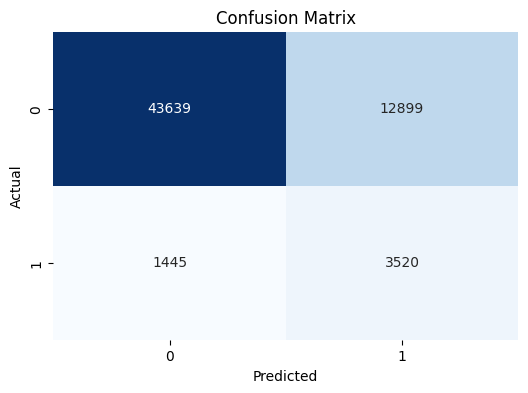

In [28]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Compared to the base and tuned models, false alarms (Class 0 predicted as risky) dropped to 12,899 (best so far), and missed risky clients (false negatives) held steady at 1,445.

### Plot ROC curve and calculate AUC to assess model discrimination capability

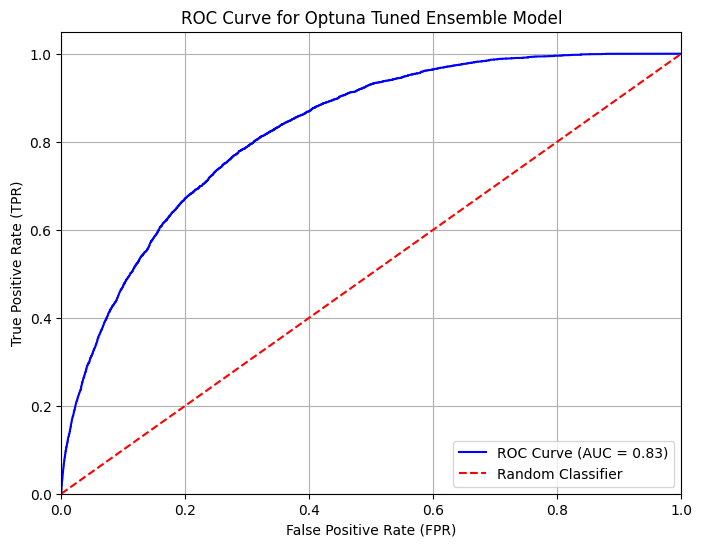

In [54]:
y_prob = optuna_ensemble.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Optuna Tuned Ensemble Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The AUC remains high at 0.83, confirming the ensemble’s reliable ability to rank risky clients above safe ones—maintaining strong balance between detection and fairness.

In [30]:
predictions = optuna_ensemble.predict_proba(test)[:, 1]

results_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})

results_df.to_csv('optuna_ensemble.csv', index=False) 

## Optuna Model with External Data

The Optuna-tuned LightGBM model has shown the best performance so far, based on AUC and classification results. Because of this, it’s the top choice for deployment.

To try and improve it further, I added more external data from datasets like bureau, previous_applications, and POS_CASH_balance. These were combined using the ID SK_ID_CURR, and a custom transformer was built to handle the merging and feature creation.

***These extra features are not available in the test set, so even if the model performs better on training and validation, we expect similar performance to the simpler Optuna model when tested.***

Since the dataset now includes many features and is heavier to process, we’ll run just 10 Optuna trials to keep things efficient.

### Define Custom Transformers

In [31]:
class DataMerger(BaseEstimator, TransformerMixin):
    def __init__(self, external_dfs, merge_key='SK_ID_CURR'):
        self.external_dfs = external_dfs
        self.merge_key = merge_key
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.merge_key not in X.columns:
            raise ValueError(f"{self.merge_key} not found in input DataFrame")
        result = X.copy()
        for df in self.external_dfs:
            if self.merge_key not in df.columns:
                raise ValueError(f"{self.merge_key} not found in external DataFrame")
            result = result.merge(df, on=self.merge_key, how='left')
        return result

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore')

### Splitting data and Features

In [32]:
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']

temp_merger = DataMerger(external_dfs=historical_data, merge_key='SK_ID_CURR')
X_merged = temp_merger.transform(X)
numerical_features = X_merged.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_merged.select_dtypes(exclude=['number']).columns.tolist()

if 'SK_ID_CURR' in numerical_features:
    numerical_features.remove('SK_ID_CURR')
if 'SK_ID_CURR' in categorical_features:
    categorical_features.remove('SK_ID_CURR')

### Redefining the pipeline

In [33]:
def build_pipeline(numerical_features, categorical_features, external_dfs, params=None):
    if params is None:
        params = {}

    merger_pipeline = Pipeline(steps=[
        ('data_merger', DataMerger(external_dfs=historical_data, merge_key='SK_ID_CURR'))
    ])

    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('feature_selector', CorrelationFeatureSelector(threshold=0.9))
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    model_pipeline = Pipeline(steps=[
        ('merger', merger_pipeline),
        ('drop_id', DropColumns(columns=['SK_ID_CURR'])),
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            is_unbalance=True,
            metric='auc',
            objective='binary',
            **params
        ))
    ])

    return model_pipeline

### Objective function for Optuna

In [36]:
def objective(trial, X, y, numerical_features, categorical_features, external_dfs):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42
    }

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = build_pipeline(numerical_features, categorical_features, external_dfs, params)
    pipeline.fit(X_train, y_train)

    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)

    return auc_score

def optimize_model(X, y, numerical_features, categorical_features, external_dfs, n_trials=50):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    objective_func = lambda trial: objective(trial, X, y, numerical_features, categorical_features, external_dfs)
    study.optimize(objective_func, n_trials=n_trials)

    print('Best trial:')
    trial = study.best_trial
    print(f'  AUC Score: {trial.value}')
    print('  Best hyperparameters:')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

    best_params = trial.params
    best_params['random_state'] = 42
    best_pipeline = build_pipeline(numerical_features, categorical_features, external_dfs, best_params)
    best_pipeline.fit(X_train, y_train)

    y_pred = best_pipeline.predict(X_val)
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    return best_pipeline, X_val, y_val

### Build and fit pipeline model

In [ ]:
optuna_external, X_val, y_val = optimize_model(X, y, numerical_features, categorical_features, historical_data, n_trials=10)
optuna_external.fit(X, y)
preds = optuna_external.predict(X_val)

[I 2025-04-15 16:11:01,704] A new study created in memory with name: no-name-3bb350cd-9279-4bd5-80bf-f7c10f95190a


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38856
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 461
[LightGBM]

[I 2025-04-15 16:13:34,635] Trial 0 finished with value: 0.7561927680304233 and parameters: {'n_estimators': 406, 'learning_rate': 0.22648248189516848, 'max_depth': 12, 'num_leaves': 98, 'min_child_samples': 19, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.7561927680304233.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38852
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 459
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.4

[I 2025-04-15 16:16:35,127] Trial 1 finished with value: 0.767359531771225 and parameters: {'n_estimators': 723, 'learning_rate': 0.001124579825911934, 'max_depth': 15, 'num_leaves': 129, 'min_child_samples': 25, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.767359531771225.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.595908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.412901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38852
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 459
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 16:19:00,801] Trial 2 finished with value: 0.7681117744381308 and parameters: {'n_estimators': 460, 'learning_rate': 0.005265139631677754, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 33, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'reg_alpha': 7.851759613930136, 'reg_lambda': 1.9967378215835974}. Best is trial 2 with value: 0.7681117744381308.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38854
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 460
[LightGBM]

[I 2025-04-15 16:21:09,118] Trial 3 finished with value: 0.7791418931352082 and parameters: {'n_estimators': 539, 'learning_rate': 0.029341527565000736, 'max_depth': 3, 'num_leaves': 99, 'min_child_samples': 21, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.08397348116461}. Best is trial 3 with value: 0.7791418931352082.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38868
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 466
[LightGBM]

[I 2025-04-15 16:23:35,972] Trial 4 finished with value: 0.7642343708350192 and parameters: {'n_estimators': 339, 'learning_rate': 0.0017456037635797405, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 16, 'subsample': 0.7475884550556351, 'colsample_bytree': 0.5171942605576092, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169}. Best is trial 3 with value: 0.7791418931352082.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38854
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 460
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.4

[I 2025-04-15 16:26:23,702] Trial 5 finished with value: 0.7786779145230209 and parameters: {'n_estimators': 680, 'learning_rate': 0.005917607170144194, 'max_depth': 9, 'num_leaves': 91, 'min_child_samples': 22, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'reg_alpha': 9.394989415641891, 'reg_lambda': 8.948273504276488}. Best is trial 3 with value: 0.7791418931352082.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38887
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 472
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.4

[I 2025-04-15 16:28:37,566] Trial 6 finished with value: 0.7755656802901281 and parameters: {'n_estimators': 618, 'learning_rate': 0.19212959255386391, 'max_depth': 4, 'num_leaves': 45, 'min_child_samples': 9, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 3 with value: 0.7791418931352082.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38824
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 448
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.4

[I 2025-04-15 16:31:12,375] Trial 7 finished with value: 0.763413775276716 and parameters: {'n_estimators': 389, 'learning_rate': 0.0049648810171066555, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 82, 'subsample': 0.5372753218398854, 'colsample_bytree': 0.9934434683002586, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 3 with value: 0.7791418931352082.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.494823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.366619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38824
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 448
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


[I 2025-04-15 16:33:17,336] Trial 8 finished with value: 0.7784712016023853 and parameters: {'n_estimators': 55, 'learning_rate': 0.10471209213501693, 'max_depth': 12, 'num_leaves': 115, 'min_child_samples': 79, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 3 with value: 0.7791418931352082.


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38852
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 459
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.4

[I 2025-04-15 16:35:29,800] Trial 9 finished with value: 0.7588266427830163 and parameters: {'n_estimators': 642, 'learning_rate': 0.006601984958164864, 'max_depth': 3, 'num_leaves': 60, 'min_child_samples': 36, 'subsample': 0.864803089169032, 'colsample_bytree': 0.8187787356776066, 'reg_alpha': 8.872127425763265, 'reg_lambda': 4.722149251619493}. Best is trial 3 with value: 0.7791418931352082.


Best trial:
  AUC Score: 0.7791418931352082
  Best hyperparameters:
    n_estimators: 539
    learning_rate: 0.029341527565000736
    max_depth: 3
    num_leaves: 99
    min_child_samples: 21
    subsample: 0.5325257964926398
    colsample_bytree: 0.9744427686266666
    reg_alpha: 9.656320330745594
    reg_lambda: 8.08397348116461
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43769
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing r

### Inspect the pipeline structure

In [ ]:
optuna_external

Pipeline(steps=[('merger',
                 Pipeline(steps=[('data_merger',
                                  DataMerger(external_dfs=[        SK_ID_CURR  BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
0           100002                   -1437                    -103   
1           100003                   -2586                    -606   
2           100004                   -1326                    -408   
3           100007                   -1149                   -1149   
4           100008                   -1097                     -78   
...            ...                     ...                     ...   
263486      456247                   -2482                    -287   
263487      456249                   -2713                    -483   
263488      456253                    -919                    -713   
263489      456254                   -1104                   -1104   
263490      456255                   -2337                    -363   

        BUREAU_DAYS_CRED...
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.9744427686266666,
                                is_unbalance=True,
                                learning_rate=0.029341527565000736, max_depth=3,
                                metric='auc', min_child_samples=21,
                                n_estimators=539, num_leaves=99,
                                objective='binary', random_state=42,
                                reg_alpha=9.656320330745594,
                                reg_lambda=8.08397348116461,
                                subsample=0.5325257964926398))])

### Evaluate model performance with classification report

In [40]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     56554
           1       0.18      0.73      0.29      4949

    accuracy                           0.71     61503
   macro avg       0.57      0.72      0.56     61503
weighted avg       0.90      0.71      0.78     61503



Compared to the Optuna-only model, recall for risky clients stayed high from 77% to 73%, but precision dropped from 0.20 to 0.18, and the F1-score fell from 0.32 to 0.29.

### Plot confusion matrix to visualize prediction accuracy

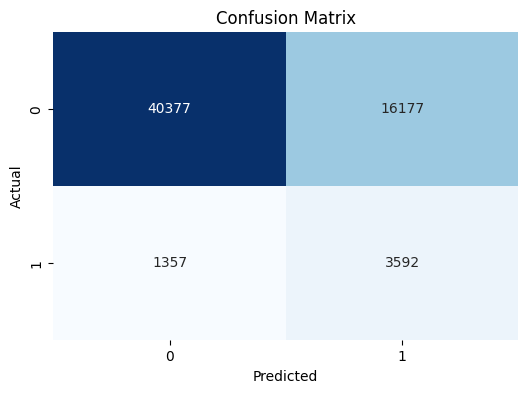

In [41]:
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

False positives increased from 15,135 to 16,177, meaning 1,042 more safe clients were wrongly flagged as risky, while false negatives slightly worsened from 1,148 to 1,357.

### Plot ROC curve and calculate AUC to assess model discrimination capability

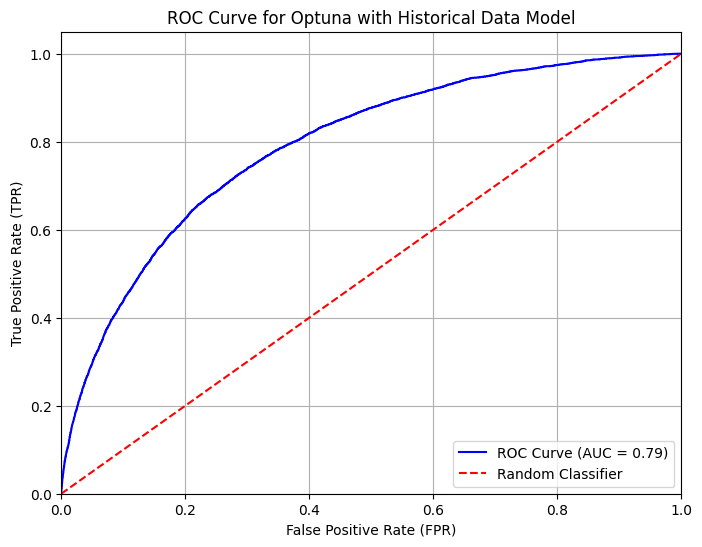

In [ ]:
y_prob = optuna_external.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Optuna with Historical Data Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

AUC decreased from 0.83 to 0.79, and overall accuracy dropped from 0.74 to 0.71, showing that the additional external data didn’t improve performance and may have added noise.

In [ ]:
predictions = optuna_external.predict_proba(test)[:, 1]

results_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': predictions})

results_df.to_csv('submissions/optuna_external.csv', index=False)

## Final Thoughts

The Optuna-tuned LightGBM model strikes the best balance between detecting risky clients and minimizing false alarms. It improved recall for class 1 (77%) while slightly boosting precision, leading to a stronger F1-score (0.32 vs. 0.27 in the base model). The AUC increased from 0.76 to 0.83, showing the model became significantly better at ranking risky clients above safe ones.

False positives were reduced by nearly 2,000 cases, and false negatives dropped by over 400, resulting in better overall accuracy and fairness. Given its strong performance on both validation and leaderboard scores—and its simplicity—this model is the best choice for deployment.

In [45]:
lgbm_optuna

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('feature_selector',
                                                                   CorrelationFeatureSelector())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID...
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5394888267036632,
                                is_unbalance=True,
                                learning_rate=0.025395203894867487,
                                max_depth=11, metric='auc',
                                min_child_samples=32, n_estimators=468,
                                num_leaves=75, objective='binary',
                                random_state=42, reg_alpha=8.683492503934032,
                                reg_lambda=5.672175923858617,
                                subsample=0.6746975441771746))])

## Model Inference and Submission Pipeline

The best-performing models overall were the Optuna-tuned LightGBM and the ensemble model. The LightGBM model with external data showed potential but didn’t outperform the simpler version—likely due to limited tuning caused by high computational cost. For deployment, I chose to keep it simple and go with the Optuna-tuned LightGBM, as it delivered the best results on both public and private leaderboard scores.

## Deploy Machine Learning Model

To ensure the trained model can be served efficiently and reliably in a production environment, I have chosen a deployment pipeline that combines portability, scalability, and ease of integration:

1. To ensure a smooth transition from experimentation to production, the final Optuna-tuned LightGBM model has been saved as a .joblib file (lgbm_optuna.joblib) and containerized using Docker. This approach promotes reproducibility and simplifies deployment across environments.

2. For scalability and accessibility, the model is served through a FastAPI interface, which enables real-time predictions via API endpoints. The FastAPI application is located in the app repository, while the core model logic is encapsulated in a separate script (lgbm_optuna.py) to avoid any notebook-related dependencies.

3. Finally, the Dockerfile—located in the main repository—packages all necessary dependencies and services into a deployable container, which is intended to be hosted on Google Cloud Platform (GCP) for robust and scalable deployment.

4. To support this deployment pipeline, a requirements.txt file is included to define all necessary Python dependencies. This ensures consistent environments across local development, Docker containers, and cloud deployments.

### Build and Test Docker Image Locally

Before proceeding with deployment, ensure that Docker is installed and running on your system. Image Name: home-credit-optuna-model (replace with your own if different). If [Docker](https://docs.docker.com/get-docker/) is not installed, follow the official installation guide for your operating system.

bash
<pre>
docker build -t home-credit-optuna-model .
docker run -p 8080:8080 home-credit-optuna-model
</pre>

Visit http://localhost:8080/docs to test the API.

### Setting up Google Cloud Platform (GCP) for Deployment

1. Visit the [Google Cloud Console](https://console.cloud.google.com/) and create a new project. Project ID: home-credit-optuna-model (replace with your own if different).
2. In the GCP console, navigate to Container Registry and click Enable to activate the service for your project. This will allow you to push and store Docker images securely.
3. Install and Configure the Google Cloud CLI (if not already)

bash
<pre>
gcloud auth login
gcloud config set project home-credit-optuna-model
</pre>

### Rebuild and Push the Image

After updating your app and Dockerfile:

bash
<pre>
docker build -t gcr.io/home-credit-optuna-model/home-credit-optuna-model .
docker push gcr.io/home-credit-optuna-model/home-credit-optuna-model
</pre>

### Redeploy to Cloud Run

bash
<pre>
gcloud run deploy home-credit-optuna-model \
  --image gcr.io/home-credit-optuna-model/home-credit-optuna-model:latest \
  --platform managed \
  --region us-central1 \
  --allow-unauthenticated
</pre>

## Test the Deployment!

Since deployment setups can vary from person to person, I’ve made it as easy as possible for you to try out my deployed machine learning model and test it yourself!

https://home-credit-optuna-model-982383075824.us-central1.run.app/docs

The deployed model is designed to be flexible and user-friendly:

* It uses only features found in the original train and test datasets (no external aggregated features).

* You **don’t need to include every feature**—even if you're missing some, the model will still return a prediction thanks to built-in preprocessing and imputation steps.
Just send a JSON payload with the available features to the API endpoint, and you'll receive a prediction in response. This makes testing quick, lightweight, and forgiving, even if you're not working with the full dataset.

Give it a try and see how well it performs on your own data!